In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

## Getting our dataset

In [2]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2024-06-23'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

In [3]:
sp500

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,XYL,Xylem Inc.,Industrials,Industrial Machinery & Supplies & Components,"White Plains, New York",2011-11-01,1524472,2011
499,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
500,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
501,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927


In [4]:
df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

[*********************100%%**********************]  503 of 503 completed


In [5]:
df

Price               Adj Close       Close        High         Low        Open  \
Date       Ticker                                                               
2016-06-27 A        39.656025   42.259998   43.709999   41.980000   43.630001   
           AAL      24.285061   25.270000   26.850000   24.850000   26.850000   
           AAPL     21.134375   23.010000   23.262501   22.875000   23.250000   
           ABBV     41.585598   58.680000   59.680000   58.330002   59.380001   
           ABT      31.891695   36.950001   37.580002   36.759998   37.509998   
...                       ...         ...         ...         ...         ...   
2024-06-21 XYL     138.669998  138.669998  139.179993  137.330002  139.179993   
           YUM     134.289993  134.289993  135.130005  133.369995  135.110001   
           ZBH     107.860001  107.860001  108.059998  106.000000  106.699997   
           ZBRA    300.010010  300.010010  301.170013  293.429993  297.709991   
           ZTS     171.089996  171.089996  171.789993  169.350006  169.380005   

Price                   Volume  
Date       Ticker               
2016-06-27 A         4328100.0  
           AAL      23170100.0  
           AAPL    181958400.0  
           ABBV      7945500.0  
           ABT      12802100.0  
...                        ...  
2024-06-21 XYL       1698300.0  
           YUM       3868100.0  
           ZBH       3318000.0  
           ZBRA       572100.0  
           ZTS       4891600.0  

[991204 rows x 6 columns]

In [6]:
df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df = df.groupby(level='ticker').filter(lambda x: len(x) >= 30) # taking only those stocks which have atleast 20 days of data

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-06-27 A        39.656025   42.259998   43.709999   41.980000   43.630001   
           AAL      24.285061   25.270000   26.850000   24.850000   26.850000   
           AAPL     21.134375   23.010000   23.262501   22.875000   23.250000   
           ABBV     41.585598   58.680000   59.680000   58.330002   59.380001   
           ABT      31.891695   36.950001   37.580002   36.759998   37.509998   
...                       ...         ...         ...         ...         ...   
2024-06-21 XYL     138.669998  138.669998  139.179993  137.330002  139.179993   
           YUM     134.289993  134.289993  135.130005  133.369995  135.110001   
           ZBH     107.860001  107.860001  108.059998  106.000000  106.699997   
           ZBRA    300.010010  300.010010  301.170013  293.429993  297.709991   
           ZTS     171.089996  171.089996  171.789993  169.350006  169.380005   

Price                   volume  
date       ticker               
2016-06-27 A         4328100.0  
           AAL      23170100.0  
           AAPL    181958400.0  
           ABBV      7945500.0  
           ABT      12802100.0  
...                        ...  
2024-06-21 XYL       1698300.0  
           YUM       3868100.0  
           ZBH       3318000.0  
           ZBRA       572100.0  
           ZTS       4891600.0  

[991204 rows x 6 columns]

In [7]:
counts = df.groupby(level='ticker').agg('count')
counts[counts['high']<=30]

Price,adj close,close,high,low,open,volume
ticker,,,,,,


In [8]:
df.isnull().sum()

Price
adj close    0
close        0
high         0
low          0
open         0
volume       0
dtype: int64

## Adding technical indicators to our dataset

In [9]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

# pandas_ta.bbands(close = np.log1p(df.xs('AAPL', level=1)['adj close']), length=20).iloc[:,0]
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

In [10]:
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-06-27 A        39.656025   42.259998   43.709999   41.980000   43.630001   
           AAL      24.285061   25.270000   26.850000   24.850000   26.850000   
           AAPL     21.134375   23.010000   23.262501   22.875000   23.250000   
           ABBV     41.585598   58.680000   59.680000   58.330002   59.380001   
           ABT      31.891695   36.950001   37.580002   36.759998   37.509998   
...                       ...         ...         ...         ...         ...   
2024-06-21 XYL     138.669998  138.669998  139.179993  137.330002  139.179993   
           YUM     134.289993  134.289993  135.130005  133.369995  135.110001   
           ZBH     107.860001  107.860001  108.059998  106.000000  106.699997   
           ZBRA    300.010010  300.010010  301.170013  293.429993  297.709991   
           ZTS     171.089996  171.089996  171.789993  169.350006  169.380005   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-06-27 A         4328100.0         -0.002708        NaN       NaN   
           AAL      23170100.0         -0.000898        NaN       NaN   
           AAPL    181958400.0         -0.003375        NaN       NaN   
           ABBV      7945500.0         -0.048752        NaN       NaN   
           ABT      12802100.0         -0.009927        NaN       NaN   
...                        ...               ...        ...       ...   
2024-06-21 XYL       1698300.0          0.000084  51.383498  4.919326   
           YUM       3868100.0          0.000072  42.732219  4.898630   
           ZBH       3318000.0          0.000140  31.530232  4.658117   
           ZBRA       572100.0          0.000316  46.300549  5.673954   
           ZTS       4891600.0          0.000063  50.703938  5.119640   

Price                bb_mid   bb_high  
date       ticker                      
2016-06-27 A            NaN       NaN  
           AAL          NaN       NaN  
           AAPL         NaN       NaN  
           ABBV         NaN       NaN  
           ABT          NaN       NaN  
...                     ...       ...  
2024-06-21 XYL     4.945033  4.970740  
           YUM     4.929555  4.960479  
           ZBH     4.722779  4.787440  
           ZBRA    5.733307  5.792660  
           ZTS     5.156229  5.192817  

[991204 rows x 11 columns]

In [11]:
df.xs('AAPL', level=1)

Price,adj close,close,high,low,open,volume,garman_klass_vol,rsi,bb_low,bb_mid,bb_high
date,,,,,,,,,,,
2016-06-27,21.134375,23.010000,23.262501,22.875000,23.250000,181958400.0,-0.003375,NaN,NaN,NaN,NaN
2016-06-28,21.490292,23.397499,23.415001,23.035000,23.225000,161779600.0,-0.002194,NaN,NaN,NaN,NaN
2016-06-29,21.676283,23.600000,23.637501,23.407499,23.492500,146124000.0,-0.002453,NaN,NaN,NaN,NaN
2016-06-30,21.951828,23.900000,23.942499,23.575001,23.610001,143345600.0,-0.001929,NaN,NaN,NaN,NaN
2016-07-01,22.018421,23.972500,24.117500,23.832500,23.872499,104106000.0,-0.002454,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2024-06-14,212.490005,212.490005,215.169998,211.300003,213.850006,70122700.0,0.000149,73.175462,5.200787,5.282489,5.364191
2024-06-17,216.669998,216.669998,218.949997,212.720001,213.369995,93728300.0,0.000326,75.359832,5.197783,5.289059,5.380335
2024-06-18,214.289993,214.289993,218.630005,213.000000,217.589996,79943300.0,0.000250,71.852979,5.197925,5.294773,5.391621


In [12]:
df.loc[pd.to_datetime('2017-04-21')]

Price,adj close,close,high,low,open,volume,garman_klass_vol,rsi,bb_low,bb_mid,bb_high
ticker,,,,,,,,,,,
A,50.514359,53.270000,53.389999,52.840000,53.259998,2189400.0,-0.001029,57.417984,3.926016,3.936237,3.946458
AAL,43.726986,45.150002,45.500000,44.990002,45.500000,5536000.0,-0.000547,57.008862,3.692711,3.749576,3.806441
AAPL,33.157005,35.567501,35.669998,35.462502,35.610001,69283600.0,-0.001951,59.242136,3.515693,3.533379,3.551065
ABBV,46.973278,63.820000,64.290001,63.549999,63.759998,4154900.0,-0.035997,50.183719,3.864024,3.880033,3.896043
ABT,38.522587,43.529999,43.980000,43.430000,43.939999,7519800.0,-0.006609,48.059233,3.661168,3.682443,3.703718
...,...,...,...,...,...,...,...,...,...,...,...
XYL,46.405956,50.650002,50.770000,50.000000,50.279999,1499700.0,-0.002367,56.711239,3.818454,3.844026,3.869597
YUM,57.202335,64.820000,65.120003,64.550003,65.019997,2595700.0,-0.006300,55.623130,4.035591,4.050142,4.064694
ZBH,111.451340,117.660194,118.514565,117.291260,118.116508,838626.0,-0.001249,56.552169,4.703865,4.717243,4.730622


In [13]:
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-06-27 A        39.656025   42.259998   43.709999   41.980000   43.630001   
           AAL      24.285061   25.270000   26.850000   24.850000   26.850000   
           AAPL     21.134375   23.010000   23.262501   22.875000   23.250000   
           ABBV     41.585598   58.680000   59.680000   58.330002   59.380001   
           ABT      31.891695   36.950001   37.580002   36.759998   37.509998   
...                       ...         ...         ...         ...         ...   
2024-06-21 XYL     138.669998  138.669998  139.179993  137.330002  139.179993   
           YUM     134.289993  134.289993  135.130005  133.369995  135.110001   
           ZBH     107.860001  107.860001  108.059998  106.000000  106.699997   
           ZBRA    300.010010  300.010010  301.170013  293.429993  297.709991   
           ZTS     171.089996  171.089996  171.789993  169.350006  169.380005   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-06-27 A         4328100.0         -0.002708        NaN       NaN   
           AAL      23170100.0         -0.000898        NaN       NaN   
           AAPL    181958400.0         -0.003375        NaN       NaN   
           ABBV      7945500.0         -0.048752        NaN       NaN   
           ABT      12802100.0         -0.009927        NaN       NaN   
...                        ...               ...        ...       ...   
2024-06-21 XYL       1698300.0          0.000084  51.383498  4.919326   
           YUM       3868100.0          0.000072  42.732219  4.898630   
           ZBH       3318000.0          0.000140  31.530232  4.658117   
           ZBRA       572100.0          0.000316  46.300549  5.673954   
           ZTS       4891600.0          0.000063  50.703938  5.119640   

Price                bb_mid   bb_high  
date       ticker                      
2016-06-27 A            NaN       NaN  
           AAL          NaN       NaN  
           AAPL         NaN       NaN  
           ABBV         NaN       NaN  
           ABT          NaN       NaN  
...                     ...       ...  
2024-06-21 XYL     4.945033  4.970740  
           YUM     4.929555  4.960479  
           ZBH     4.722779  4.787440  
           ZBRA    5.733307  5.792660  
           ZTS     5.156229  5.192817  

[991204 rows x 11 columns]

In [14]:
def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-06-27 A        39.656025   42.259998   43.709999   41.980000   43.630001   
           AAL      24.285061   25.270000   26.850000   24.850000   26.850000   
           AAPL     21.134375   23.010000   23.262501   22.875000   23.250000   
           ABBV     41.585598   58.680000   59.680000   58.330002   59.380001   
           ABT      31.891695   36.950001   37.580002   36.759998   37.509998   
...                       ...         ...         ...         ...         ...   
2024-06-21 XYL     138.669998  138.669998  139.179993  137.330002  139.179993   
           YUM     134.289993  134.289993  135.130005  133.369995  135.110001   
           ZBH     107.860001  107.860001  108.059998  106.000000  106.699997   
           ZBRA    300.010010  300.010010  301.170013  293.429993  297.709991   
           ZTS     171.089996  171.089996  171.789993  169.350006  169.380005   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-06-27 A         4328100.0         -0.002708        NaN       NaN   
           AAL      23170100.0         -0.000898        NaN       NaN   
           AAPL    181958400.0         -0.003375        NaN       NaN   
           ABBV      7945500.0         -0.048752        NaN       NaN   
           ABT      12802100.0         -0.009927        NaN       NaN   
...                        ...               ...        ...       ...   
2024-06-21 XYL       1698300.0          0.000084  51.383498  4.919326   
           YUM       3868100.0          0.000072  42.732219  4.898630   
           ZBH       3318000.0          0.000140  31.530232  4.658117   
           ZBRA       572100.0          0.000316  46.300549  5.673954   
           ZTS       4891600.0          0.000063  50.703938  5.119640   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2016-06-27 A            NaN       NaN       NaN       NaN     171.635242  
           AAL          NaN       NaN       NaN       NaN     562.687289  
           AAPL         NaN       NaN       NaN       NaN    3845.576991  
           ABBV         NaN       NaN       NaN       NaN     330.418369  
           ABT          NaN       NaN       NaN       NaN     408.280669  
...                     ...       ...       ...       ...            ...  
2024-06-21 XYL     4.945033  4.970740  0.740581 -0.026276     235.503258  
           YUM     4.929555  4.960479  0.343925 -0.685034     519.447123  
           ZBH     4.722779  4.787440 -0.675892 -1.398608     357.879482  
           ZBRA    5.733307  5.792660 -0.185508 -0.528475     171.635727  
           ZTS     5.156229  5.192817  0.544530  0.057223     836.903826  

[991204 rows x 14 columns]

## 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.
To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [15]:
cols = [c for c in df.columns if c not in ['close', 'high', 'low', 'open', 'dollar_volume', 'volume']]

In [16]:
data = pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                  df.unstack('ticker')[cols].resample('M').last().stack('ticker')], axis=1)
data

dollar_volume   adj close       atr   bb_high    bb_low  \
date       ticker                                                            
2016-06-30 A          133.827197   41.736320       NaN       NaN       NaN   
           AAL        445.184292   27.206570       NaN       NaN       NaN   
           AAPL      3409.097721   21.951828       NaN       NaN       NaN   
           ABBV       376.610985   43.874653       NaN       NaN       NaN   
           ABT        328.040391   33.928627       NaN       NaN       NaN   
...                          ...         ...       ...       ...       ...   
2024-06-30 XYL        156.030146  138.669998  0.740581  4.970740  4.919326   
           YUM        271.877713  134.289993  0.343925  4.960479  4.898630   
           ZBH        191.786214  107.860001 -0.675892  4.787440  4.658117   
           ZBRA        84.261003  300.010010 -0.185508  5.792660  5.673954   
           ZTS        408.150142  171.089996  0.544530  5.192817  5.119640   

                     bb_mid  garman_klass_vol      macd        rsi  
date       ticker                                                   
2016-06-30 A            NaN         -0.000631       NaN        NaN  
           AAL          NaN          0.000214       NaN        NaN  
           AAPL         NaN         -0.001929       NaN        NaN  
           ABBV         NaN         -0.045187       NaN        NaN  
           ABT          NaN         -0.006377       NaN        NaN  
...                     ...               ...       ...        ...  
2024-06-30 XYL     4.945033          0.000084 -0.026276  51.383498  
           YUM     4.929555          0.000072 -0.685034  42.732219  
           ZBH     4.722779          0.000140 -1.398608  31.530232  
           ZBRA    5.733307          0.000316 -0.528475  46.300549  
           ZTS     5.156229          0.000063  0.057223  50.703938  

[47833 rows x 9 columns]

In [17]:
data['dollar_volume'] = data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack()
data['dollar_vol_rank'] = data.groupby('date')['dollar_volume'].rank(ascending=False)
data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)
data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2017-05-31 AAL      46.985195  0.571498  3.886832  3.763660  3.825246   
           AAPL     35.748730 -1.220778  3.637560  3.567802  3.602681   
           ABBV     48.592545 -1.629152  3.921028  3.889572  3.905300   
           ABT      40.407566 -1.378746  3.719186  3.659323  3.689255   
           ACN     112.053123 -1.254794  4.725428  4.687239  4.706334   
...                       ...       ...       ...       ...       ...   
2024-06-30 VZ       40.240002 -0.685926  3.754879  3.684941  3.719910   
           WFC      58.099998  0.016819  4.117342  4.056800  4.087071   
           WMT      67.910004  0.891000  4.240376  4.180736  4.210556   
           XOM     110.760002  0.615329  4.768903  4.693644  4.731274   
           ZTS     171.089996  0.544530  5.192817  5.119640  5.156229   

                   garman_klass_vol      macd        rsi  
date       ticker                                         
2017-05-31 AAL            -0.000056  1.302841  60.617179  
           AAPL           -0.002044 -0.039488  61.065258  
           ABBV           -0.037005 -0.158727  54.400068  
           ABT            -0.004774 -0.044672  64.674986  
           ACN            -0.003928  0.055915  62.532439  
...                             ...       ...        ...  
2024-06-30 VZ              0.000067 -0.039299  50.928993  
           WFC             0.000189 -0.518877  46.943631  
           WMT             0.000046  2.356676  69.284248  
           XOM             0.000110 -1.398474  43.634695  
           ZTS             0.000063  0.057223  50.703938  

[12814 rows x 8 columns]

## 4. Calculate Monthly Returns for different time horizons as features.
To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [18]:
df = data.copy()

In [19]:
def monthly_returns(df):
    outlier_cutoff = 0.005
    lags = [1,2,3,6,12]
    for lag in lags:
        df[f'return_{lag}m'] = (df['adj close'].pct_change(lag).pipe(lambda x: x.clip(lower = x.quantile(outlier_cutoff),
                                                                                    upper = x.quantile(1-outlier_cutoff))).add(1).pow(1/lag).sub(1))
    return df

data = data.groupby(level=1, group_keys=False).apply(monthly_returns).dropna()
data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2018-05-31 AAL      42.618011  1.381624  3.801628  3.728982  3.765305   
           AAPL     44.410904 -1.058824  3.844051  3.784342  3.814196   
           ABBV     75.292389  0.459886  4.422443  4.323378  4.372910   
           ABT      55.550396 -0.798791  4.066919  3.981285  4.024102   
           ACN     142.810822 -0.880006  4.982193  4.942734  4.962464   
...                       ...       ...       ...       ...       ...   
2024-06-30 VRTX    468.709991  1.177219  6.212178  6.090735  6.151457   
           VZ       40.240002 -0.685926  3.754879  3.684941  3.719910   
           WFC      58.099998  0.016819  4.117342  4.056800  4.087071   
           WMT      67.910004  0.891000  4.240376  4.180736  4.210556   
           XOM     110.760002  0.615329  4.768903  4.693644  4.731274   

                   garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2018-05-31 AAL             0.000660 -0.580016  45.114579   0.016581   
           AAPL           -0.001003  0.103486  59.945516   0.135124   
           ABBV           -0.032834  0.076676  46.193239   0.024754   
           ABT            -0.004457  0.290931  54.184913   0.058490   
           ACN            -0.002942 -0.004490  53.108634   0.030027   
...                             ...       ...        ...        ...   
2024-06-30 VRTX            0.000119  2.229027  59.836299   0.029363   
           VZ              0.000067 -0.039299  50.928993  -0.022114   
           WFC             0.000189 -0.518877  46.943631  -0.030374   
           WMT             0.000046  2.356676  69.284248   0.032695   
           XOM             0.000110 -1.398474  43.634695  -0.055432   

                   return_2m  return_3m  return_6m  return_12m  
date       ticker                                               
2018-05-31 AAL     -0.083533  -0.069961  -0.023688   -0.008097  
           AAPL     0.057391   0.017418   0.015402    0.018245  
           ABBV     0.027693  -0.047916   0.006367    0.037166  
           ABT      0.015782   0.008199   0.016325    0.026878  
           ACN      0.011705  -0.008131   0.009999    0.020418  
...                      ...        ...        ...         ...  
2024-06-30 VRTX     0.092348   0.038897   0.023854    0.024172  
           VZ       0.009451  -0.008560   0.016465    0.012618  
           WFC     -0.007496   0.002719   0.030214    0.028553  
           WMT      0.071536   0.042361   0.044856    0.023055  
           XOM     -0.028348  -0.013311   0.020156    0.005583  

[10646 rows x 13 columns]

In [20]:
data.xs('AAPL', level=1).head(20)

,adj close,atr,bb_high,bb_low,bb_mid,garman_klass_vol,macd,rsi,return_1m,return_2m,return_3m,return_6m,return_12m
date,,,,,,,,,,,,,
2018-05-31,44.410904,-1.058824,3.844051,3.784342,3.814196,-0.001003,0.103486,59.945516,0.135124,0.057391,0.017418,0.015402,0.018245
2018-06-30,43.992641,-1.044963,3.861789,3.786773,3.824281,-0.000987,-0.331484,49.582465,-0.009418,0.060393,0.034635,0.016401,0.022450
2018-07-31,45.223686,-1.067548,3.860463,3.808181,3.834322,-0.000885,-0.157754,52.605249,0.027983,0.009109,0.049478,0.022909,0.022060
2018-08-31,54.287529,-0.967183,4.008456,3.897968,3.953212,-0.000608,0.494034,81.062372,0.200422,0.110862,0.069228,0.043001,0.028984
2018-09-30,53.836781,-0.820173,4.019256,3.959550,3.989403,-0.000679,-0.016359,61.186145,-0.008303,0.091080,0.069629,0.051986,0.033607
2018-10-31,52.195950,-0.439282,4.015217,3.938486,3.976851,-0.000406,-0.437663,50.232883,-0.030478,-0.019453,0.048955,0.049216,0.023037
2018-11-30,42.738174,-0.510632,3.960706,3.708259,3.834483,-0.000922,-1.358918,36.859855,-0.157264,-0.109019,-0.076638,-0.006378,0.004453
2018-12-31,37.750706,-0.533762,3.811428,3.587240,3.699334,-0.000748,-1.270283,37.072847,-0.116698,-0.132505,-0.100989,-0.025181,-0.004607
2019-01-31,39.832806,-0.701188,3.699384,3.566801,3.633093,-0.000316,-0.340372,53.482568,0.055154,-0.034589,-0.086164,-0.020933,0.000748


## 5. Download Fama-French Factors and Calculate Rolling Factor Betas.
We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [21]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

type(factor_data.index)

pandas.core.indexes.period.PeriodIndex

In [22]:
factor_data.index = factor_data.index.to_timestamp()
type(factor_data.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [23]:
factor_data = factor_data.resample('M').last().div(100)

factor_data

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
2010-01-31,-0.0336,0.0034,0.0043,-0.0127,0.0046
2010-02-28,0.0340,0.0151,0.0323,-0.0027,0.0143
2010-03-31,0.0631,0.0185,0.0221,-0.0065,0.0169
2010-04-30,0.0200,0.0498,0.0289,0.0069,0.0172
2010-05-31,-0.0789,0.0004,-0.0244,0.0130,-0.0021
...,...,...,...,...,...
2023-12-31,0.0487,0.0732,0.0493,-0.0307,0.0132
2024-01-31,0.0070,-0.0574,-0.0238,0.0069,-0.0096
2024-02-29,0.0506,-0.0078,-0.0349,-0.0199,-0.0214


In [24]:
factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW    CMA  return_1m
date       ticker                                                  
2018-05-31 AAL     0.0265  0.0473 -0.0320 -0.0204 -0.015   0.016581
           AAPL    0.0265  0.0473 -0.0320 -0.0204 -0.015   0.135124
           ABBV    0.0265  0.0473 -0.0320 -0.0204 -0.015   0.024754
           ABT     0.0265  0.0473 -0.0320 -0.0204 -0.015   0.058490
           ACN     0.0265  0.0473 -0.0320 -0.0204 -0.015   0.030027
...                   ...     ...     ...     ...    ...        ...
2024-04-30 VRTX   -0.0467 -0.0255 -0.0051  0.0147 -0.003  -0.060286
           VZ     -0.0467 -0.0255 -0.0051  0.0147 -0.003  -0.043625
           WFC    -0.0467 -0.0255 -0.0051  0.0147 -0.003   0.023464
           WMT    -0.0467 -0.0255 -0.0051  0.0147 -0.003  -0.013628
           XOM    -0.0467 -0.0255 -0.0051  0.0147 -0.003   0.017464

[10362 rows x 6 columns]

In [25]:
observations = factor_data.groupby(level=1).size()
# observations
valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW    CMA  return_1m
date       ticker                                                  
2018-05-31 AAL     0.0265  0.0473 -0.0320 -0.0204 -0.015   0.016581
           AAPL    0.0265  0.0473 -0.0320 -0.0204 -0.015   0.135124
           ABBV    0.0265  0.0473 -0.0320 -0.0204 -0.015   0.024754
           ABT     0.0265  0.0473 -0.0320 -0.0204 -0.015   0.058490
           ACN     0.0265  0.0473 -0.0320 -0.0204 -0.015   0.030027
...                   ...     ...     ...     ...    ...        ...
2024-04-30 VRTX   -0.0467 -0.0255 -0.0051  0.0147 -0.003  -0.060286
           VZ     -0.0467 -0.0255 -0.0051  0.0147 -0.003  -0.043625
           WFC    -0.0467 -0.0255 -0.0051  0.0147 -0.003   0.023464
           WMT    -0.0467 -0.0255 -0.0051  0.0147 -0.003  -0.013628
           XOM    -0.0467 -0.0255 -0.0051  0.0147 -0.003   0.017464

[10320 rows x 6 columns]

In [26]:
# calculating rolling factor betas
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-05-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-04-30 VRTX    0.366069  0.640066 -0.678316  0.325818  0.739600
           VZ      0.445431 -1.034769  0.572071  0.109871 -0.072812
           WFC     1.099293  0.259486  1.225701 -0.520460 -0.781068
           WMT     0.609515  0.128324 -0.665645  0.617155  0.467713
           XOM     0.792216 -0.106076  0.684834  0.876684  0.322891

[10320 rows x 5 columns]

In [27]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10470 entries, (Timestamp('2018-05-31 00:00:00'), 'AAL') to (Timestamp('2024-06-30 00:00:00'), 'XOM')
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               10470 non-null  float64
 1   bb_high           10470 non-null  float64
 2   bb_low            10470 non-null  float64
 3   bb_mid            10470 non-null  float64
 4   garman_klass_vol  10470 non-null  float64
 5   macd              10470 non-null  float64
 6   rsi               10470 non-null  float64
 7   return_1m         10470 non-null  float64
 8   return_2m         10470 non-null  float64
 9   return_3m         10470 non-null  float64
 10  return_6m         10470 non-null  float64
 11  return_12m        10470 non-null  float64
 12  Mkt-RF            10470 non-null  float64
 13  SMB               10470 non-null  float64
 14  HML               10470 non-null  float64
 15  RMW        

In [28]:
data

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2018-05-31 AAL     1.381624  3.801628  3.728982  3.765305          0.000660   
           AAPL   -1.058824  3.844051  3.784342  3.814196         -0.001003   
           ABBV    0.459886  4.422443  4.323378  4.372910         -0.032834   
           ABT    -0.798791  4.066919  3.981285  4.024102         -0.004457   
           ACN    -0.880006  4.982193  4.942734  4.962464         -0.002942   
...                     ...       ...       ...       ...               ...   
2024-06-30 VRTX    1.177219  6.212178  6.090735  6.151457          0.000119   
           VZ     -0.685926  3.754879  3.684941  3.719910          0.000067   
           WFC     0.016819  4.117342  4.056800  4.087071          0.000189   
           WMT     0.891000  4.240376  4.180736  4.210556          0.000046   
           XOM     0.615329  4.768903  4.693644  4.731274          0.000110   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2018-05-31 AAL    -0.580016  45.114579   0.016581  -0.083533  -0.069961   
           AAPL    0.103486  59.945516   0.135124   0.057391   0.017418   
           ABBV    0.076676  46.193239   0.024754   0.027693  -0.047916   
           ABT     0.290931  54.184913   0.058490   0.015782   0.008199   
           ACN    -0.004490  53.108634   0.030027   0.011705  -0.008131   
...                     ...        ...        ...        ...        ...   
2024-06-30 VRTX    2.229027  59.836299   0.029363   0.092348   0.038897   
           VZ     -0.039299  50.928993  -0.022114   0.009451  -0.008560   
           WFC    -0.518877  46.943631  -0.030374  -0.007496   0.002719   
           WMT     2.356676  69.284248   0.032695   0.071536   0.042361   
           XOM    -1.398474  43.634695  -0.055432  -0.028348  -0.013311   

                   return_6m  return_12m    Mkt-RF       SMB       HML  \
date       ticker                                                        
2018-05-31 AAL     -0.023688   -0.008097  1.228554  1.420697  0.459370   
           AAPL     0.015402    0.018245  1.318245 -0.345442 -0.615873   
           ABBV     0.006367    0.037166  0.462683  0.533154 -0.186512   
           ABT      0.016325    0.026878  0.800186 -0.143542 -0.456684   
           ACN      0.009999    0.020418  1.216351 -0.187499 -0.263720   
...                      ...         ...       ...       ...       ...   
2024-06-30 VRTX     0.023854    0.024172  0.502754  0.036397 -0.872997   
           VZ       0.016465    0.012618  0.471912 -0.433104  0.196184   
           WFC      0.030214    0.028553  1.074416 -0.085421  1.550929   
           WMT      0.044856    0.023055  0.604001 -0.391738 -0.369233   
           XOM      0.020156    0.005583  1.083300  0.183793  0.791274   

                        RMW       CMA  
date       ticker                      
2018-05-31 AAL     0.073208  0.803640  
           AAPL    0.436585  0.603411  
           ABBV    0.532682  0.419814  
           ABT     0.255199  0.953829  
           ACN     0.311088  0.113072  
...                     ...       ...  
2024-06-30 VRTX    0.145146  0.863153  
           VZ      0.235430  0.276501  
           WFC    -0.760558 -0.810634  
           WMT     0.261042  0.690967  
           XOM    -0.438637  0.495479  

[10470 rows x 17 columns]

## 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
### K-Means Clustering
You may want to initialize predefined centroids for each cluster based on your research.

For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

Then we will pre-define our centroids for each cluster.

In [29]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 17))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.]])

In [30]:
from sklearn.cluster import KMeans

# data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2018-05-31 AAL     1.381624  3.801628  3.728982  3.765305          0.000660   
           AAPL   -1.058824  3.844051  3.784342  3.814196         -0.001003   
           ABBV    0.459886  4.422443  4.323378  4.372910         -0.032834   
           ABT    -0.798791  4.066919  3.981285  4.024102         -0.004457   
           ACN    -0.880006  4.982193  4.942734  4.962464         -0.002942   
...                     ...       ...       ...       ...               ...   
2024-06-30 VRTX    1.177219  6.212178  6.090735  6.151457          0.000119   
           VZ     -0.685926  3.754879  3.684941  3.719910          0.000067   
           WFC     0.016819  4.117342  4.056800  4.087071          0.000189   
           WMT     0.891000  4.240376  4.180736  4.210556          0.000046   
           XOM     0.615329  4.768903  4.693644  4.731274          0.000110   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2018-05-31 AAL    -0.580016  45.114579   0.016581  -0.083533  -0.069961   
           AAPL    0.103486  59.945516   0.135124   0.057391   0.017418   
           ABBV    0.076676  46.193239   0.024754   0.027693  -0.047916   
           ABT     0.290931  54.184913   0.058490   0.015782   0.008199   
           ACN    -0.004490  53.108634   0.030027   0.011705  -0.008131   
...                     ...        ...        ...        ...        ...   
2024-06-30 VRTX    2.229027  59.836299   0.029363   0.092348   0.038897   
           VZ     -0.039299  50.928993  -0.022114   0.009451  -0.008560   
           WFC    -0.518877  46.943631  -0.030374  -0.007496   0.002719   
           WMT     2.356676  69.284248   0.032695   0.071536   0.042361   
           XOM    -1.398474  43.634695  -0.055432  -0.028348  -0.013311   

                   return_6m  return_12m    Mkt-RF       SMB       HML  \
date       ticker                                                        
2018-05-31 AAL     -0.023688   -0.008097  1.228554  1.420697  0.459370   
           AAPL     0.015402    0.018245  1.318245 -0.345442 -0.615873   
           ABBV     0.006367    0.037166  0.462683  0.533154 -0.186512   
           ABT      0.016325    0.026878  0.800186 -0.143542 -0.456684   
           ACN      0.009999    0.020418  1.216351 -0.187499 -0.263720   
...                      ...         ...       ...       ...       ...   
2024-06-30 VRTX     0.023854    0.024172  0.502754  0.036397 -0.872997   
           VZ       0.016465    0.012618  0.471912 -0.433104  0.196184   
           WFC      0.030214    0.028553  1.074416 -0.085421  1.550929   
           WMT      0.044856    0.023055  0.604001 -0.391738 -0.369233   
           XOM      0.020156    0.005583  1.083300  0.183793  0.791274   

                        RMW       CMA  cluster  
date       ticker                               
2018-05-31 AAL     0.073208  0.803640        1  
           AAPL    0.436585  0.603411        2  
           ABBV    0.532682  0.419814        1  
           ABT     0.255199  0.953829        2  
           ACN     0.311088  0.113072        2  
...                     ...       ...      ...  
2024-06-30 VRTX    0.145146  0.863153        2  
           VZ      0.235430  0.276501        1  
           WFC    -0.760558 -0.810634        1  
           WMT     0.261042  0.690967        3  
           XOM    -0.438637  0.495479        1  

[10470 rows x 18 columns]

In [31]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return

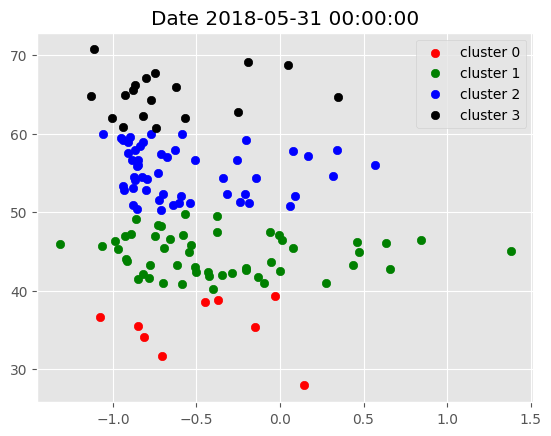

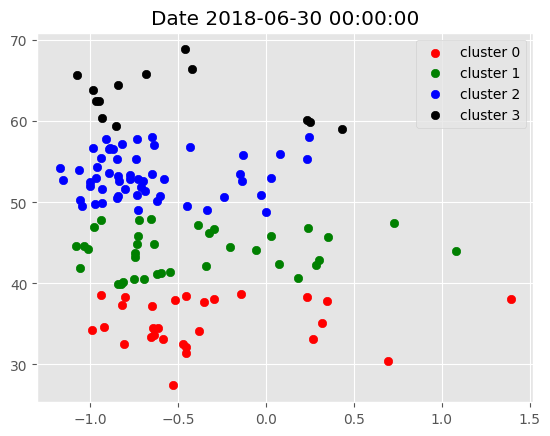

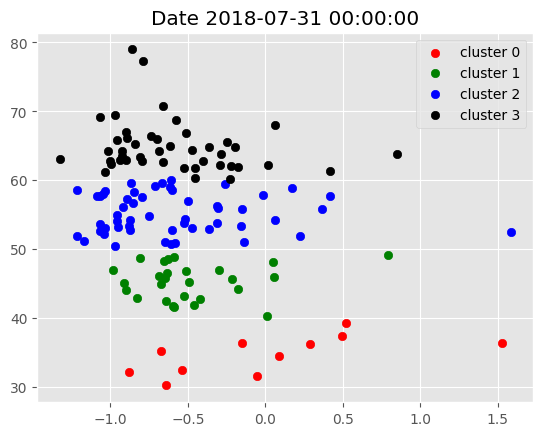

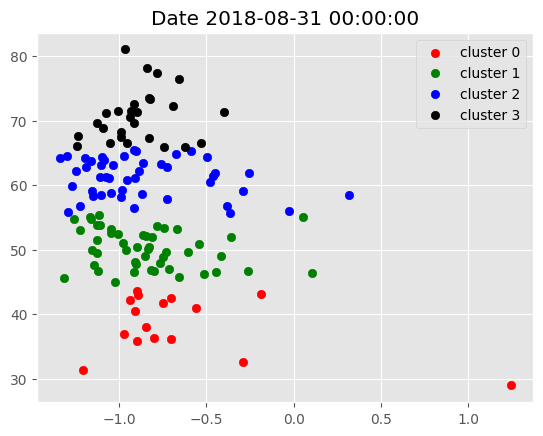

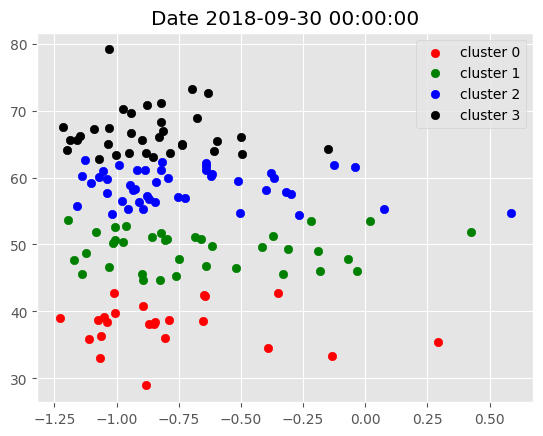

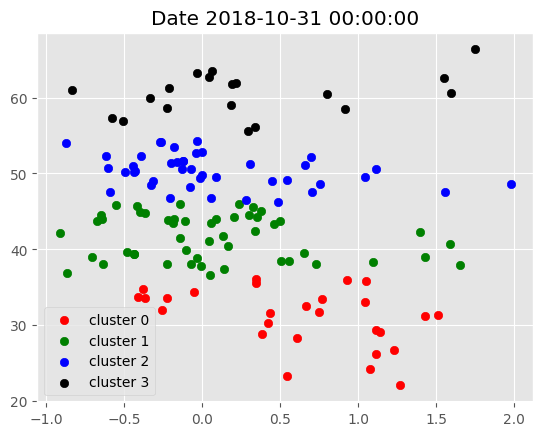

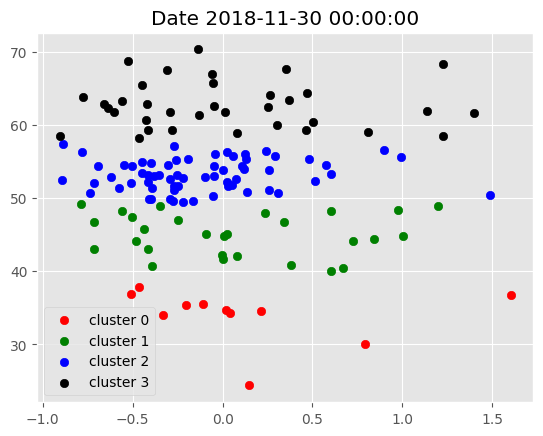

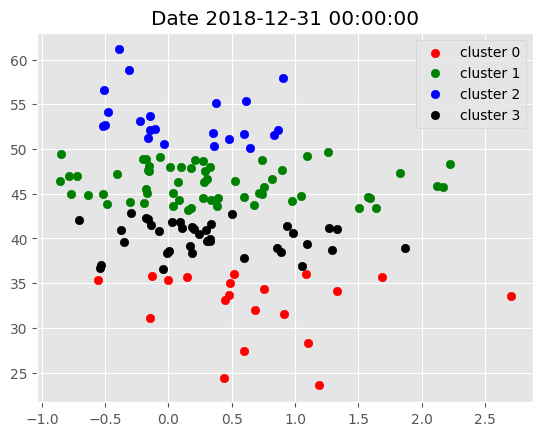

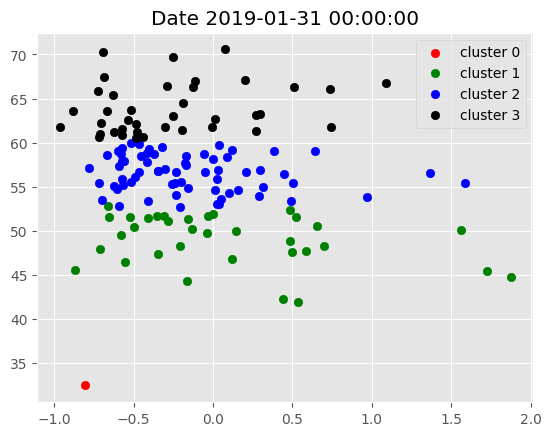

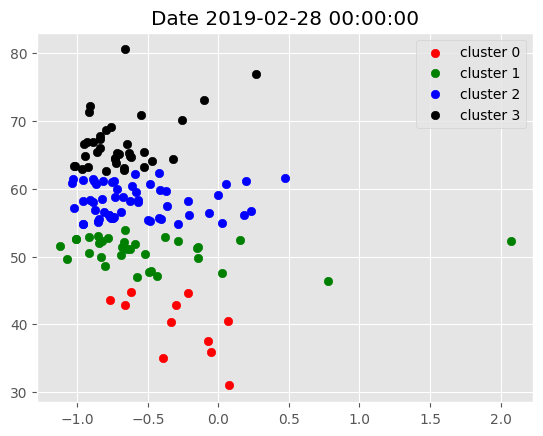

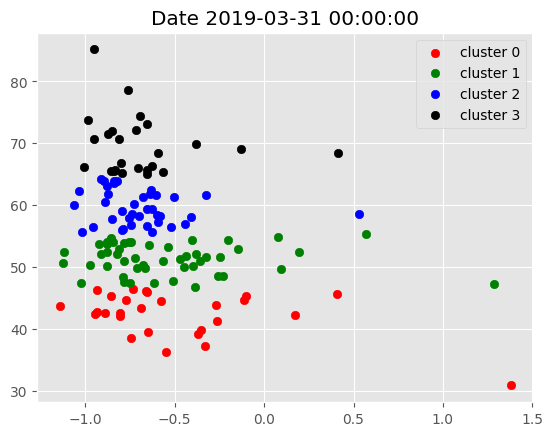

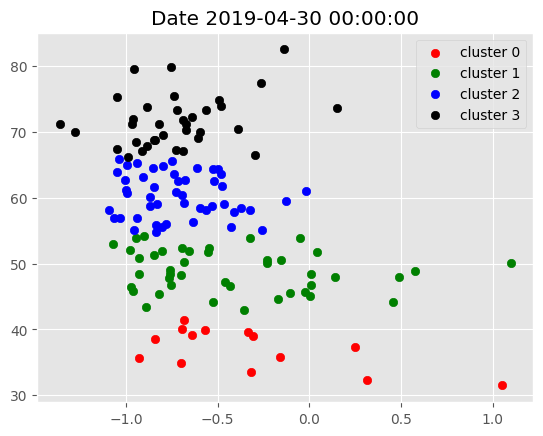

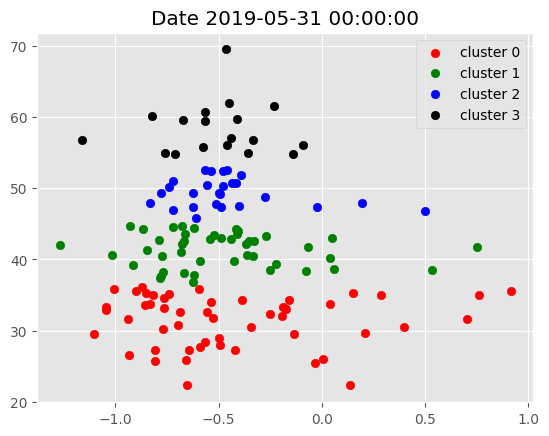

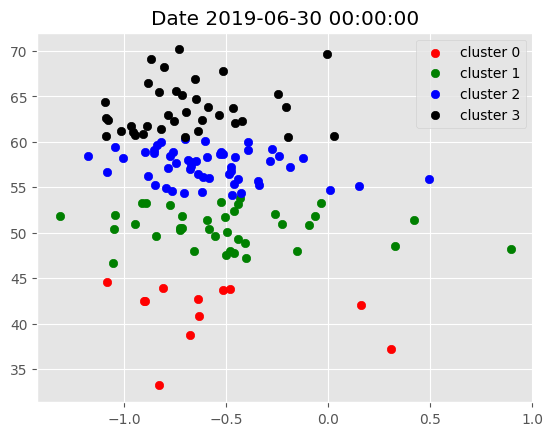

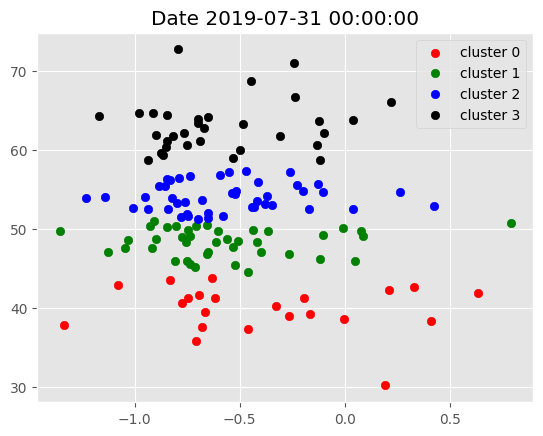

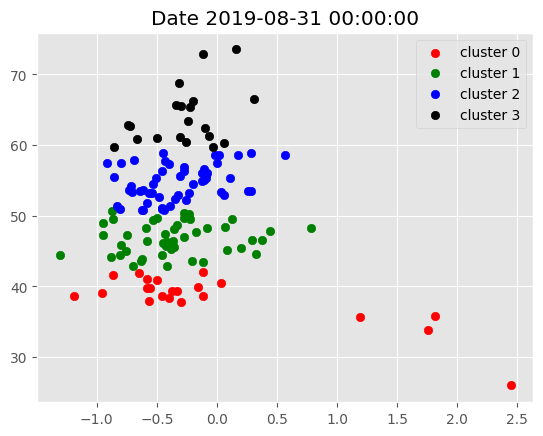

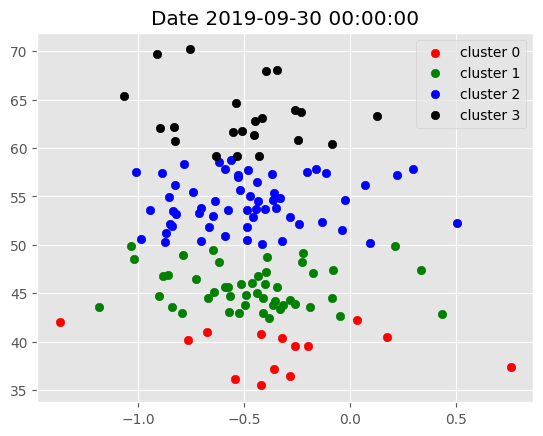

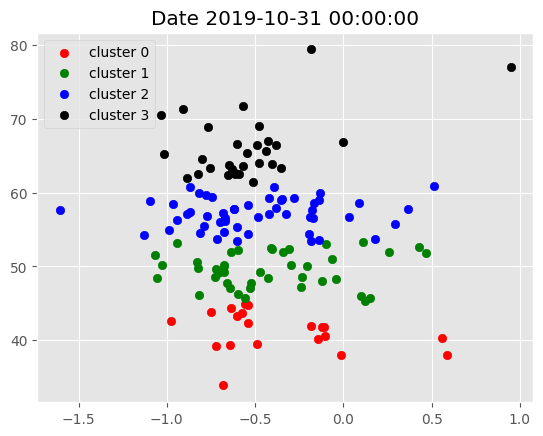

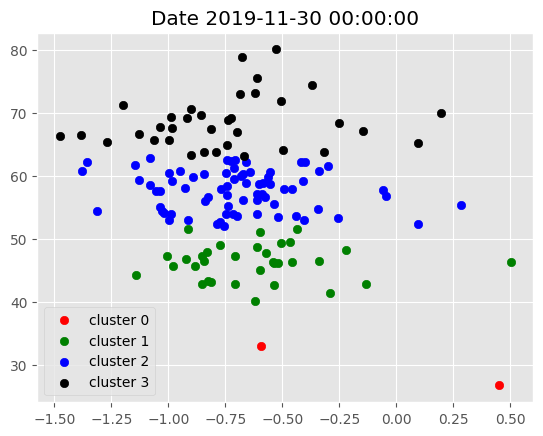

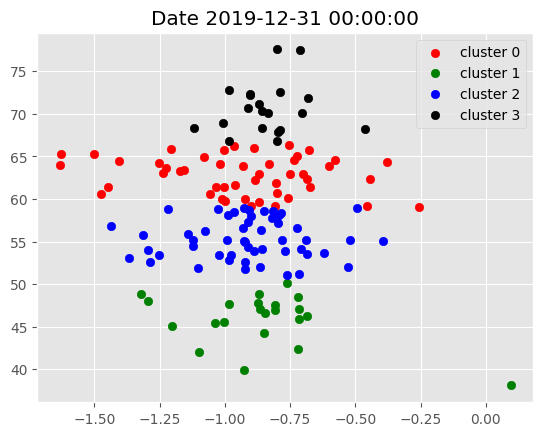

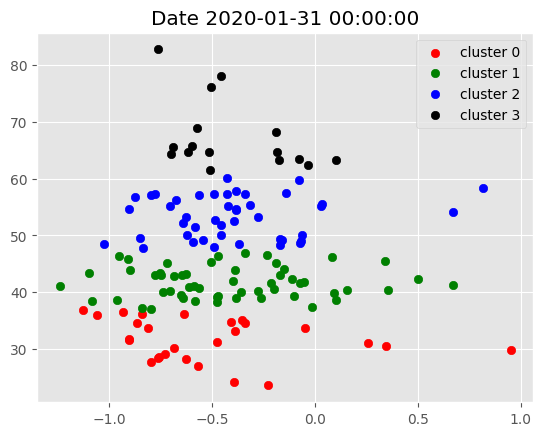

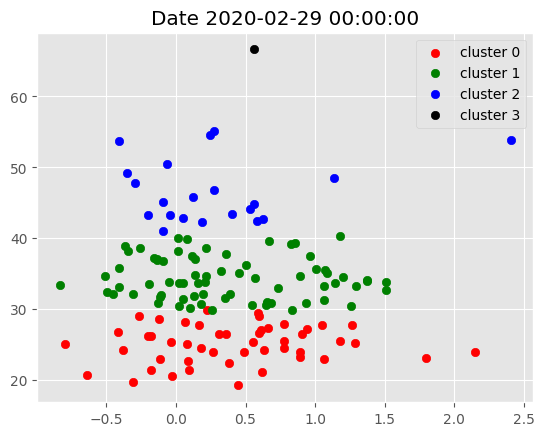

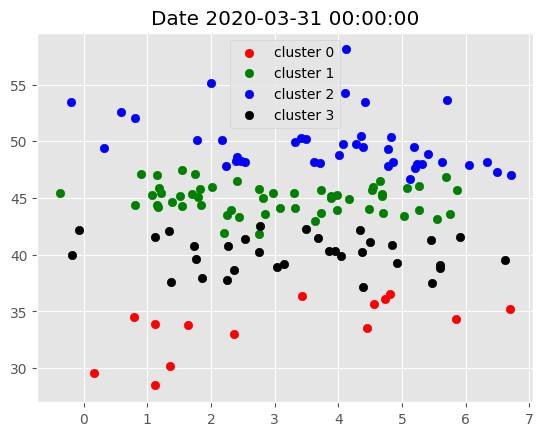

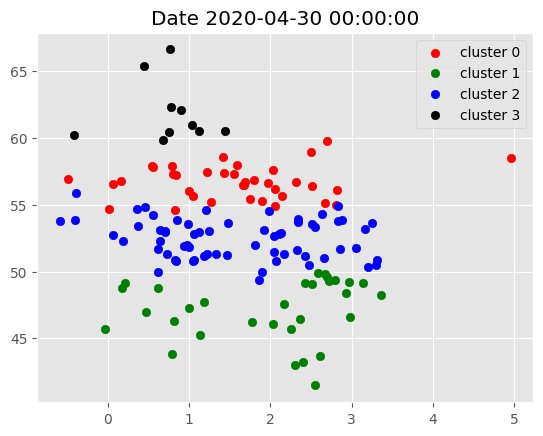

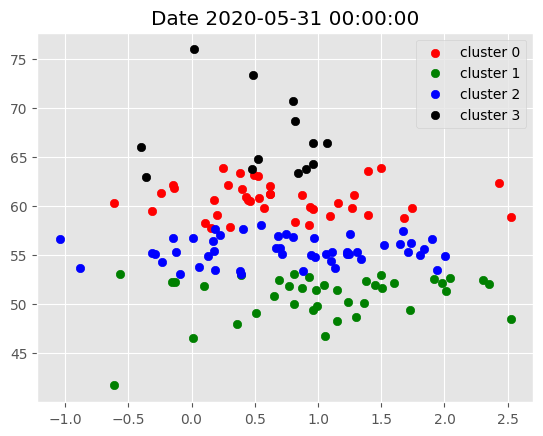

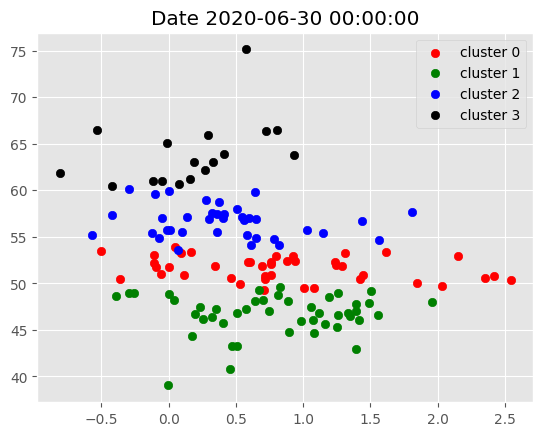

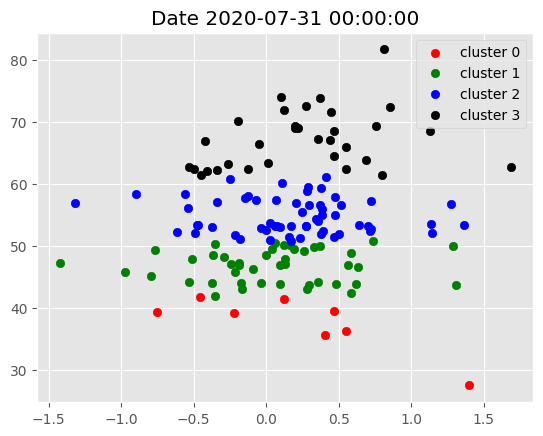

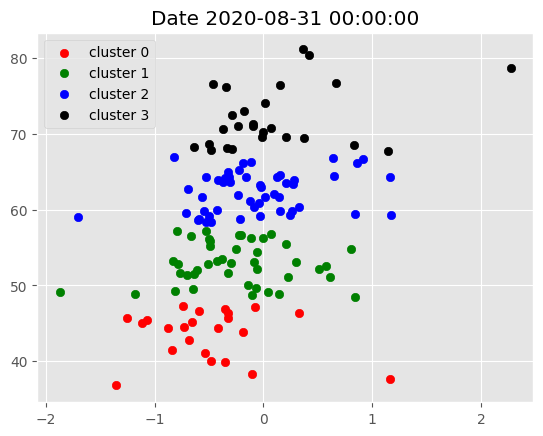

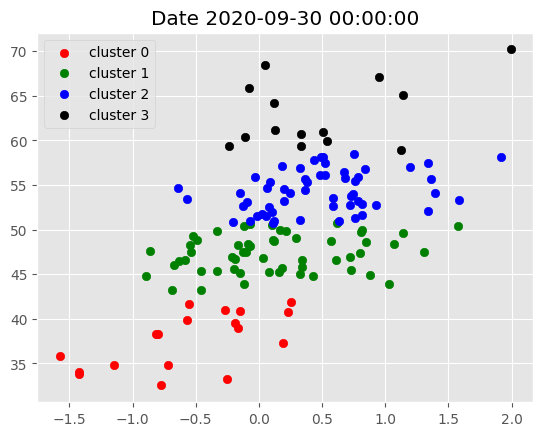

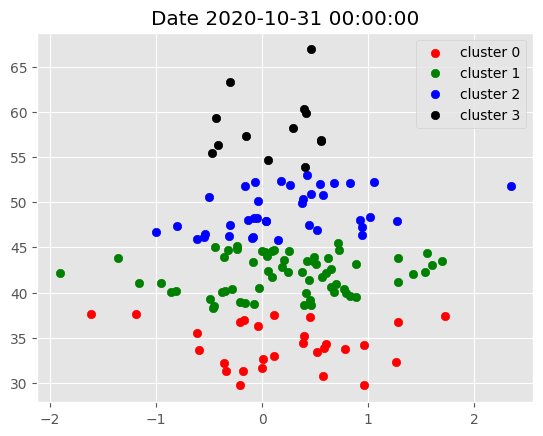

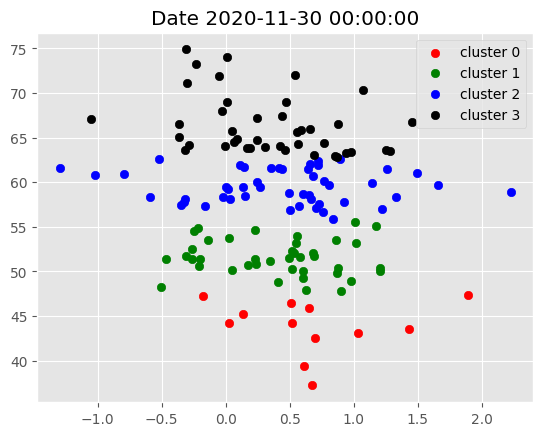

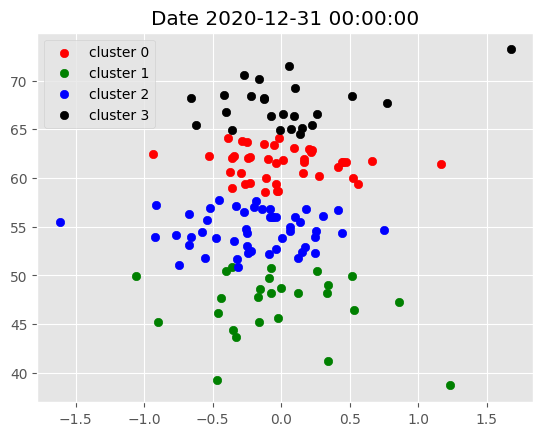

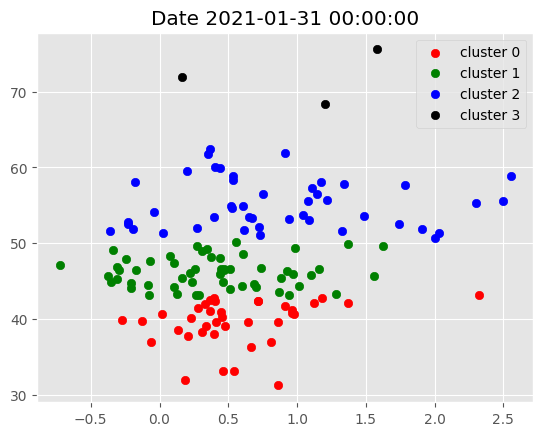

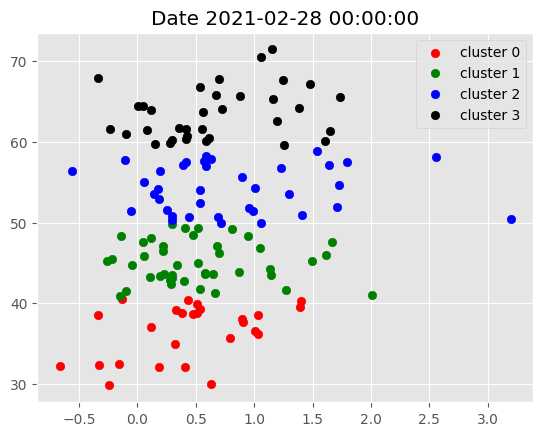

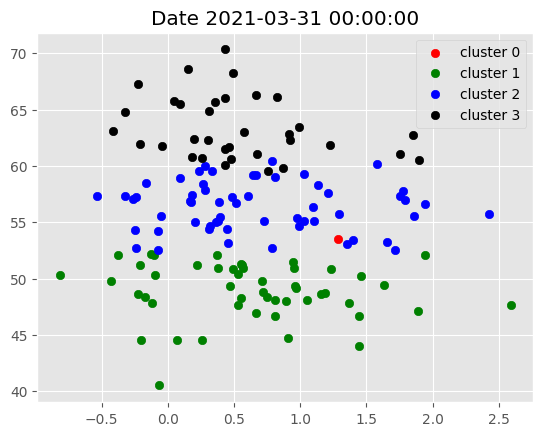

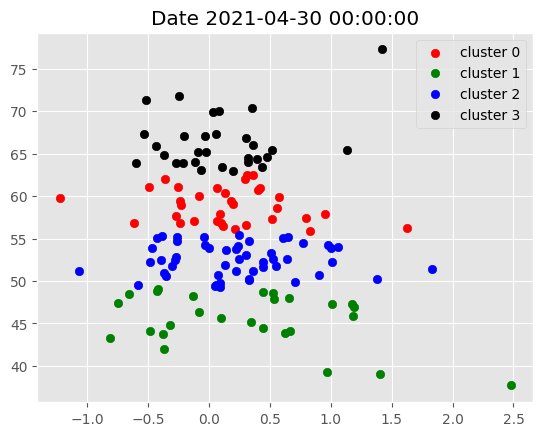

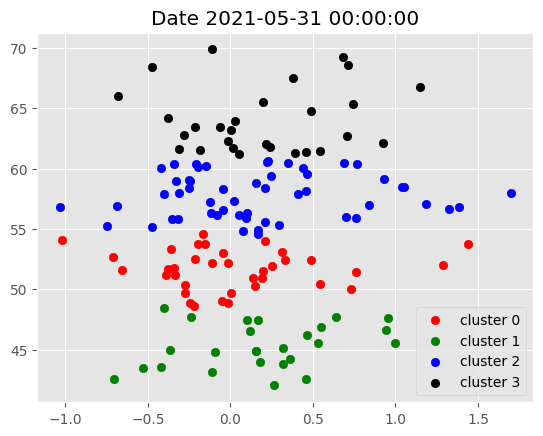

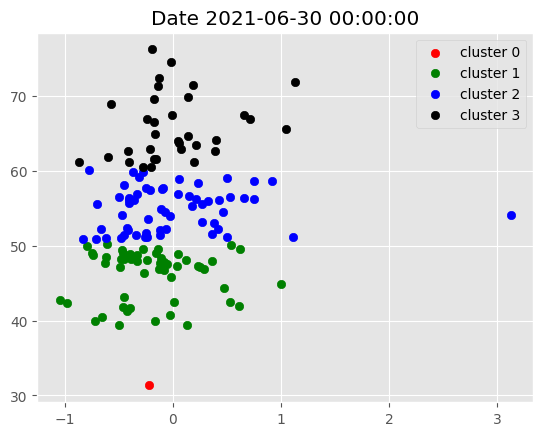

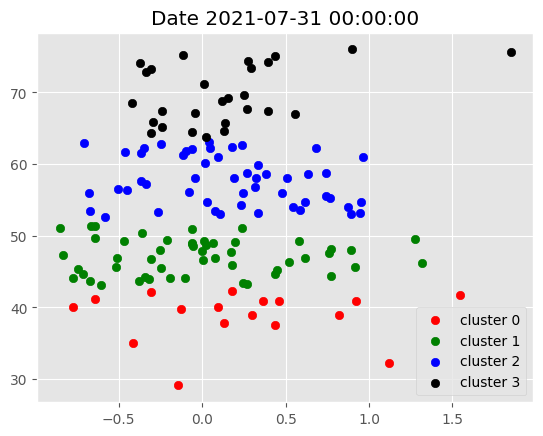

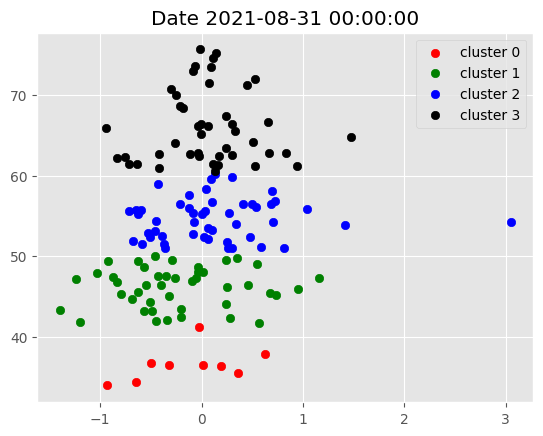

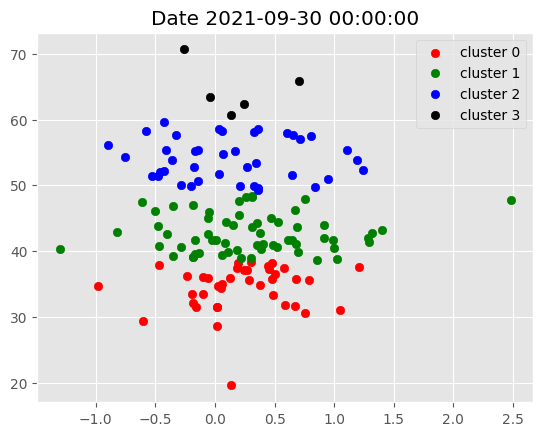

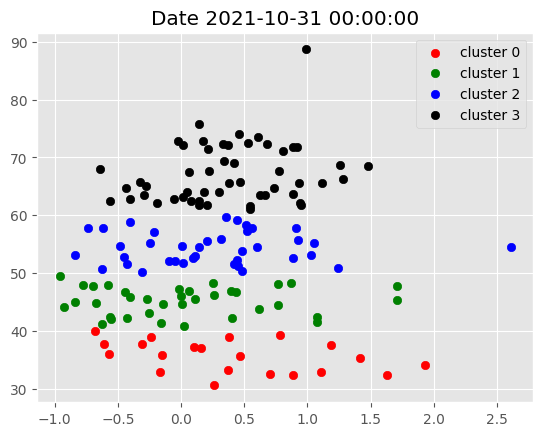

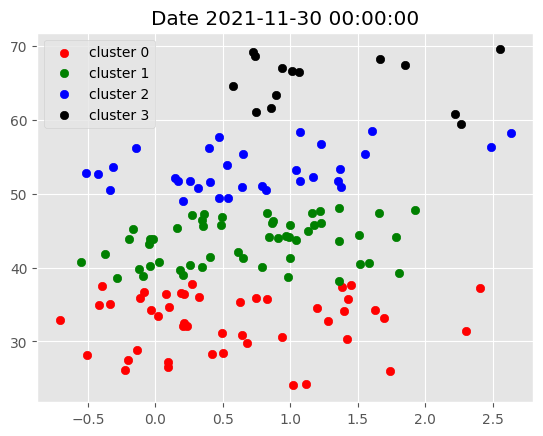

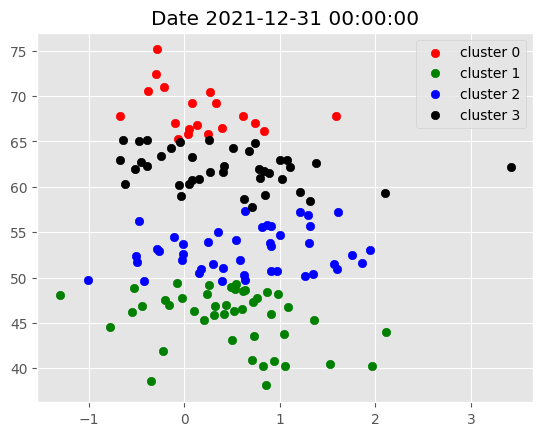

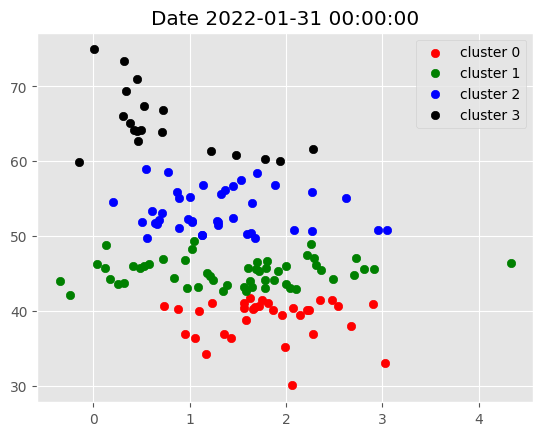

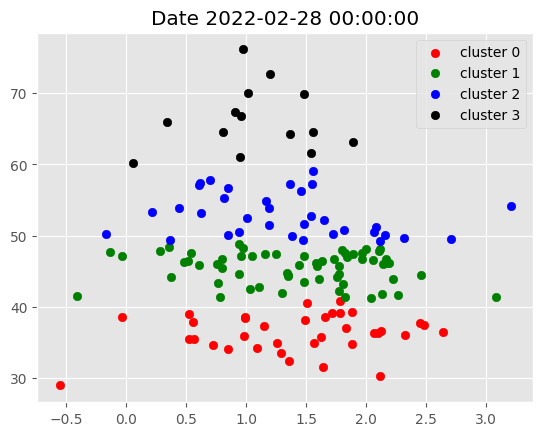

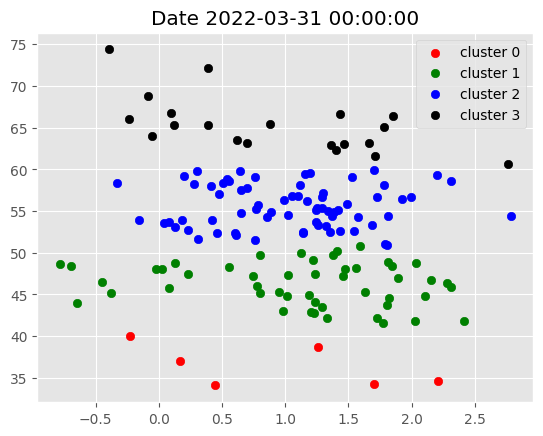

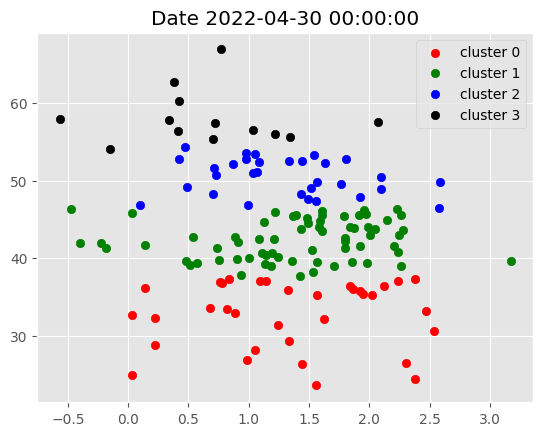

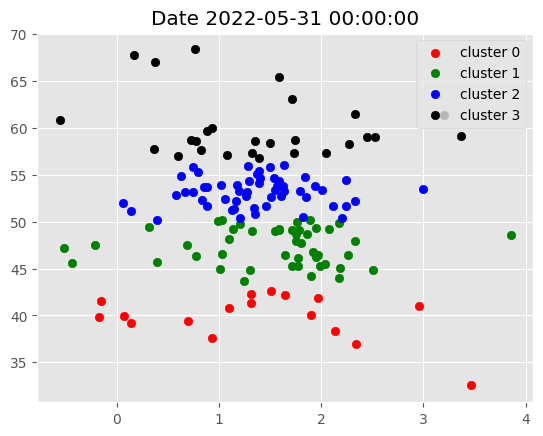

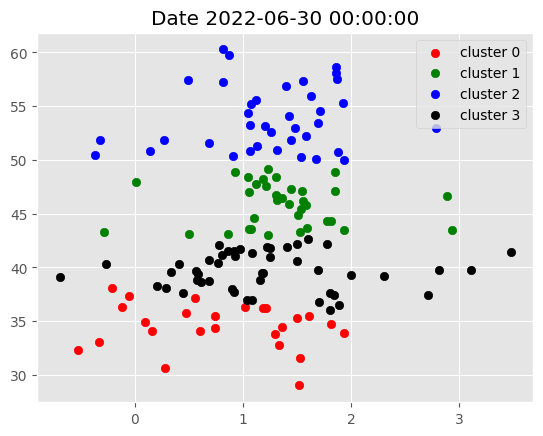

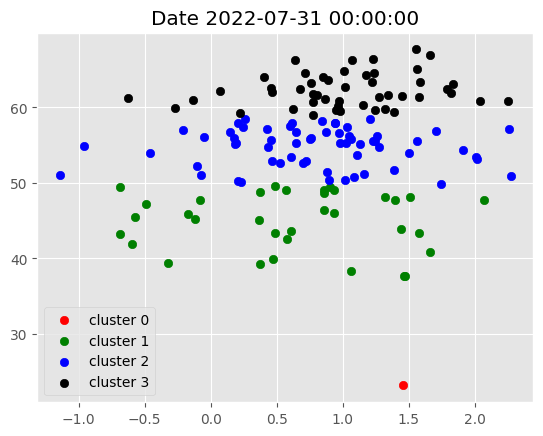

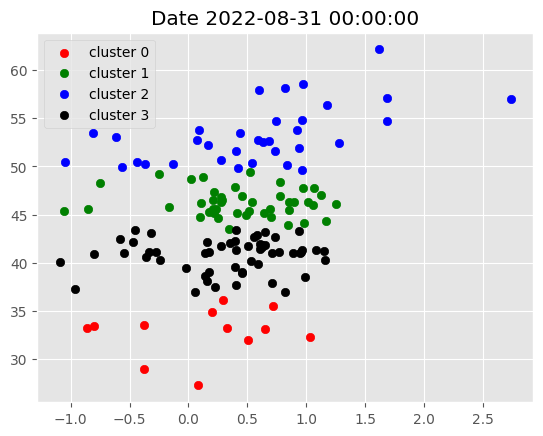

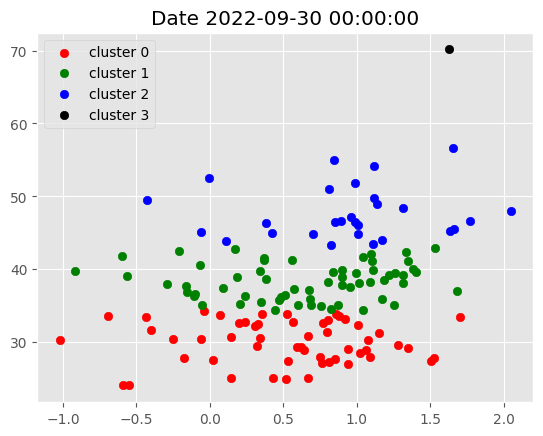

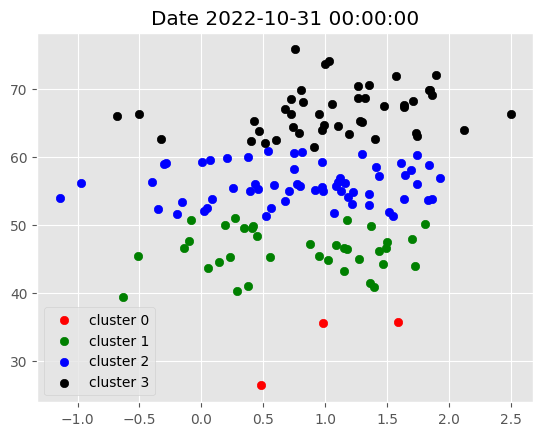

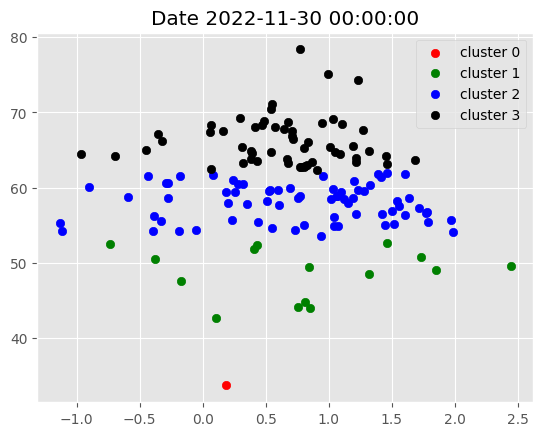

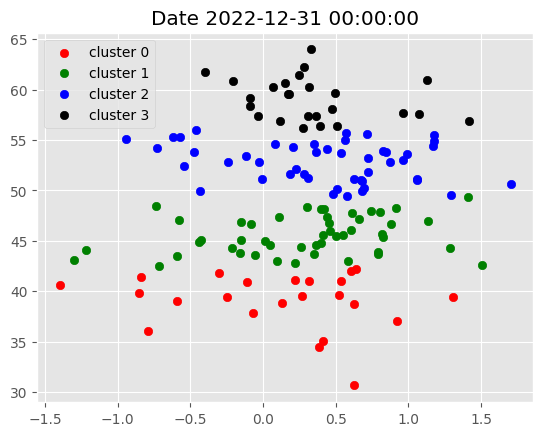

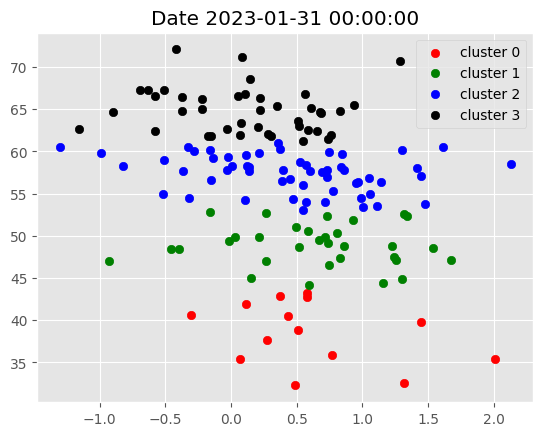

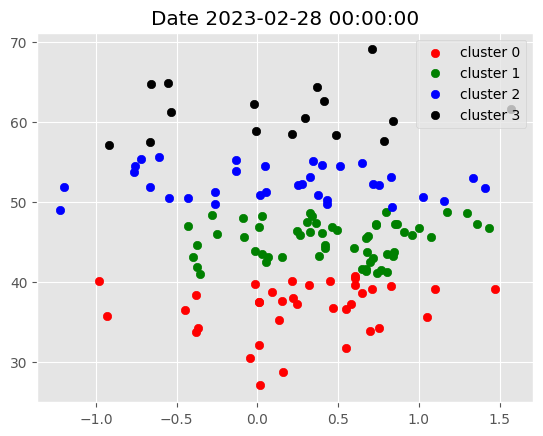

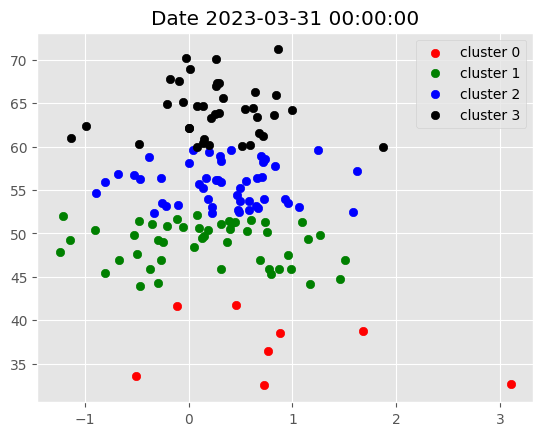

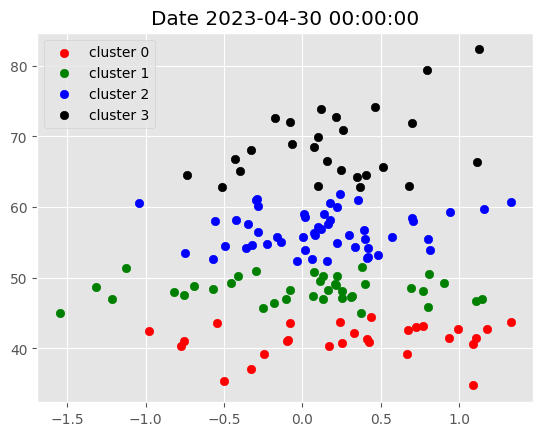

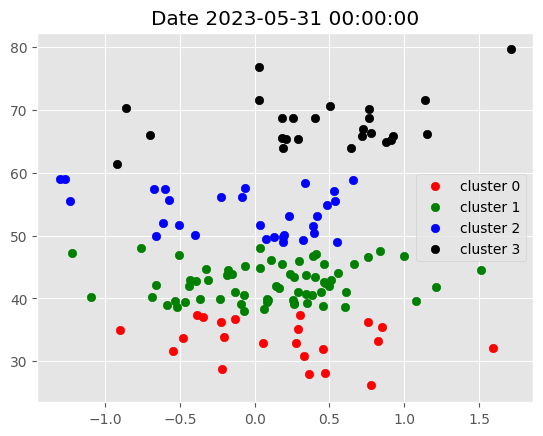

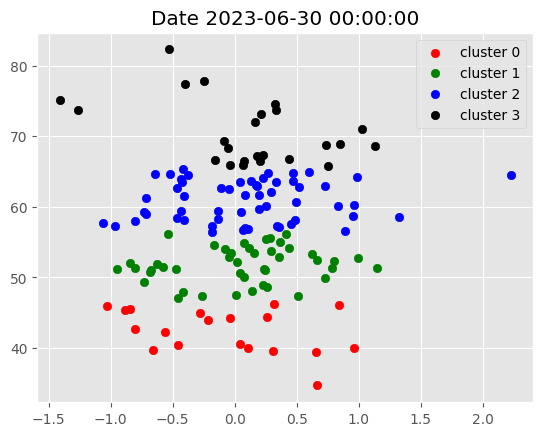

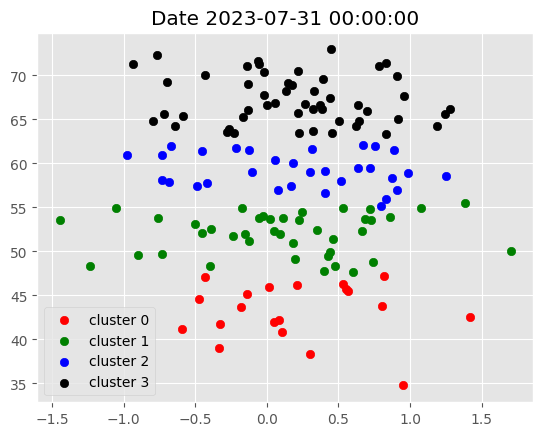

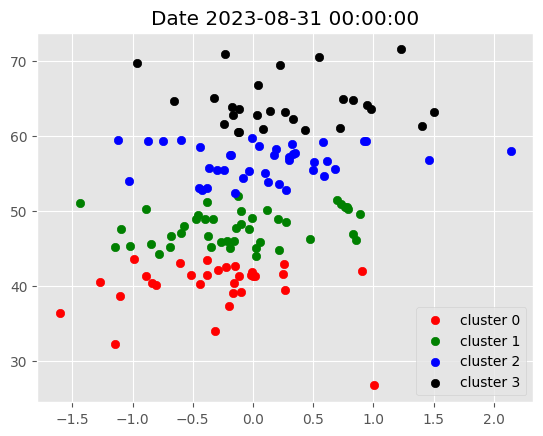

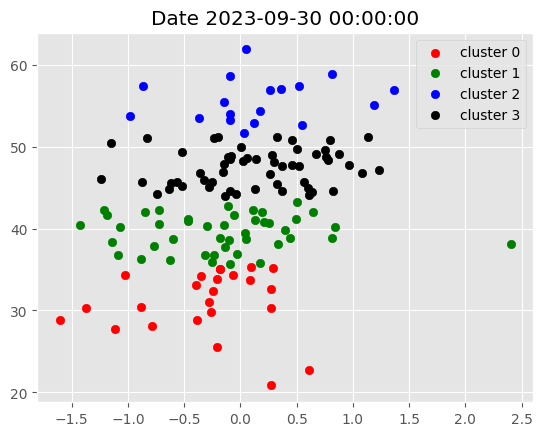

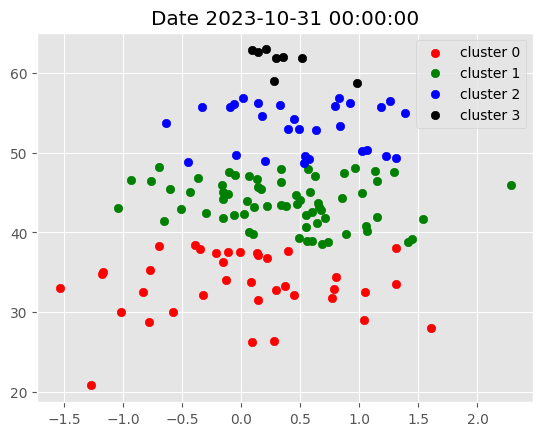

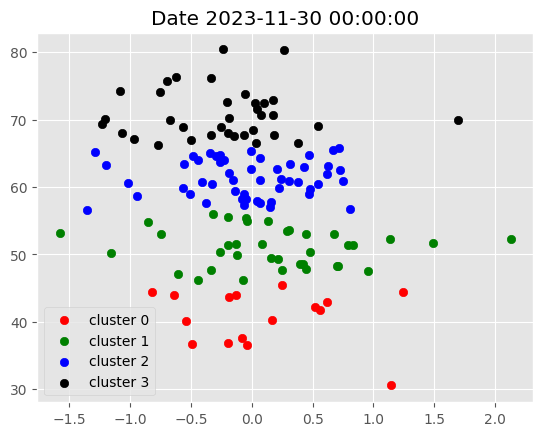

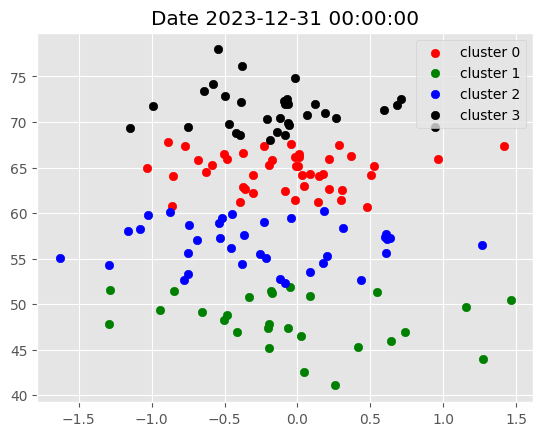

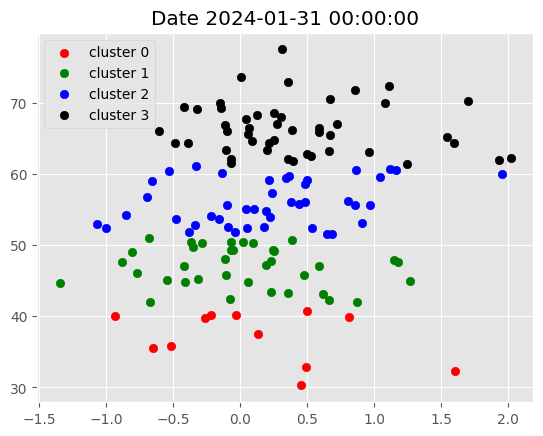

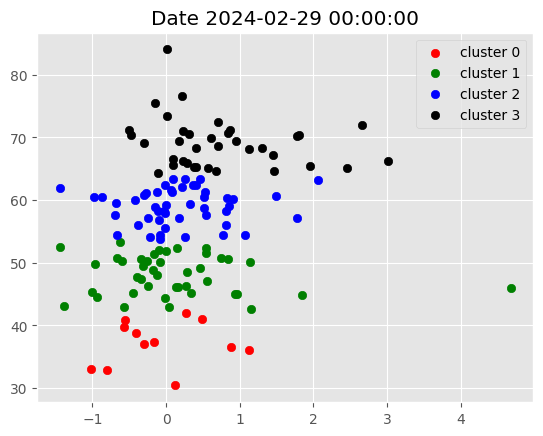

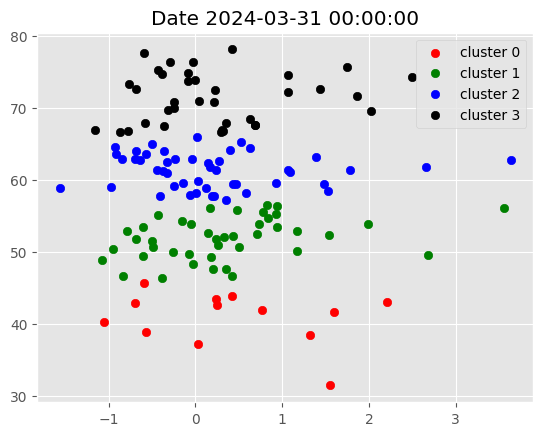

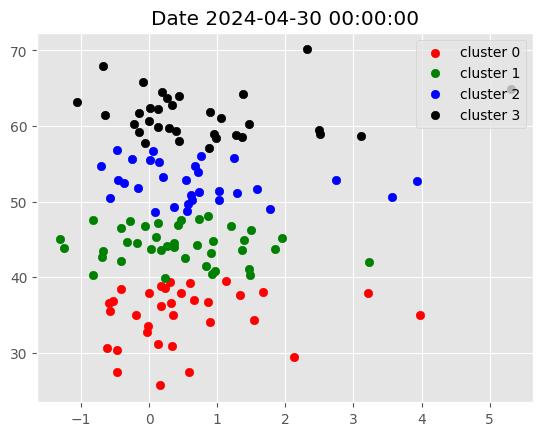

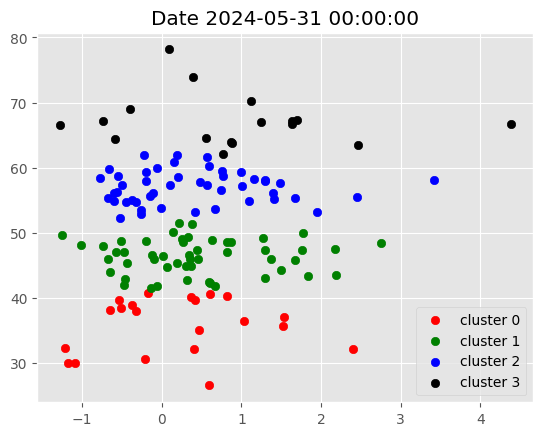

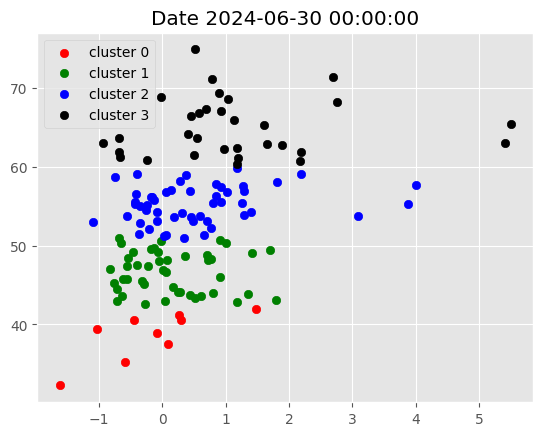

In [32]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

## 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization
- First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

- Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.

In [70]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index + pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().to_list()

fixed_dates = {}

for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.unique().to_list()

fixed_dates  # now we have a list of stocks which we would like to invest in on that date(key of the dictionary)

{'2018-06-01': ['ADBE',
  'AMD',
  'AMZN',
  'BIIB',
  'CMG',
  'CSX',
  'EXPE',
  'GM',
  'LLY',
  'LOW',
  'META',
  'NEE',
  'NFLX',
  'OXY',
  'PANW',
  'TJX',
  'TXN',
  'VLO'],
 '2018-07-01': ['AMT',
  'COST',
  'EA',
  'EOG',
  'KR',
  'NEE',
  'NFLX',
  'NKE',
  'PEP',
  'PG',
  'REGN',
  'SHW',
  'TJX'],
 '2018-08-01': ['ABT',
  'AMD',
  'AMGN',
  'AMT',
  'BDX',
  'BMY',
  'C',
  'CMCSA',
  'COST',
  'CSX',
  'DIS',
  'ELV',
  'EOG',
  'EXPE',
  'GILD',
  'HON',
  'JNJ',
  'JPM',
  'KO',
  'LLY',
  'LMT',
  'LUV',
  'MDLZ',
  'MDT',
  'MMM',
  'MRK',
  'ORLY',
  'PEP',
  'PFE',
  'PG',
  'PM',
  'QCOM',
  'REGN',
  'RTX',
  'SHW',
  'TGT',
  'TJX',
  'TMO',
  'UAL',
  'UNP',
  'UPS',
  'USB',
  'VLO',
  'WMT'],
 '2018-09-01': ['AAPL',
  'ADP',
  'AMD',
  'AMZN',
  'BDX',
  'COST',
  'CSCO',
  'CVS',
  'DAL',
  'ISRG',
  'LLY',
  'LOW',
  'LUV',
  'MDT',
  'MSFT',
  'NVDA',
  'ORLY',
  'PANW',
  'QCOM',
  'REGN',
  'SHW',
  'TGT',
  'TJX',
  'TMO',
  'UAL',
  'UNH',
  'V'],
 '

- Define portfolio optimization function
- We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

- To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

- Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [111]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

In [75]:
# Download Fresh Daily Prices Data only for short listed stocks.

stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  157 of 157 completed


Price       Adj Close                                                  \
Ticker            AAL        AAPL        ABBV         ABT         ACN   
Date                                                                    
2017-05-31  46.985199   35.748726   48.592545   40.407570  112.053123   
2017-06-01  47.606358   35.846996   49.100399   40.796951  112.791321   
2017-06-02  48.062523   36.378235   49.497841   41.150936  113.196419   
2017-06-05  48.276058   36.022518   49.689224   41.257133  113.952629   
2017-06-06  48.276058   36.144222   49.954197   41.027046  113.727577   
...               ...         ...         ...         ...         ...   
2024-06-14  11.280000  212.490005  168.589996  103.680000  286.709991   
2024-06-17  11.440000  216.669998  169.679993  103.449997  285.529999   
2024-06-18  11.280000  214.289993  171.360001  103.989998  285.350006   
2024-06-20  11.240000  209.679993  172.130005  106.570000  306.160004   
2024-06-21  11.200000  207.490005  170.389999  105.720001  308.980011   

Price                                                                  ...  \
Ticker            ADBE         ADI         ADP        ADSK        AIG  ...   
Date                                                                   ...   
2017-05-31  141.860001   74.552055   87.813805  111.769997  52.567802  ...   
2017-06-01  141.380005   71.465996   88.654472  113.029999  52.790867  ...   
2017-06-02  143.479996   70.335876   86.621468  112.910004  53.071758  ...   
2017-06-05  143.589996   68.458176   86.724403  110.879997  52.733036  ...   
2017-06-06  143.029999   69.631760   86.810165  111.449997  52.303436  ...   
...                ...         ...         ...         ...        ...  ...   
2024-06-14  525.309998  231.190002  242.619995  225.869995  73.419998  ...   
2024-06-17  518.739990  232.389999  244.960007  240.509995  73.980003  ...   
2024-06-18  522.250000  235.380005  244.410004  244.119995  74.129997  ...   
2024-06-20  522.950012  229.509995  246.059998  243.509995  74.879997  ...   
2024-06-21  533.440002  231.050003  247.970001  242.309998  74.889999  ...   

Price         Volume                                                           \
Ticker             V      VLO     VRTX        VZ       WBA      WDC       WFC   
Date                                                                            
2017-05-31   9866000  4655900  2813600  22811100   4355600  5531700  30519700   
2017-06-01   8911900  3541400  3356300  14219400   3692500  3520300  21001800   
2017-06-02   8570200  2788900  2837100  18552800   3940900  3191100  19477300   
2017-06-05  14510500  3897100  2030000   8538200   2824000  4286100  13663800   
2017-06-06   7030300  2579800  1250600  11610500   6663800  3626200  14887500   
...              ...      ...      ...       ...       ...      ...       ...   
2024-06-14   8537300  2641800   641800  10480600   9046100  3152400  15375400   
2024-06-17   9258200  1804000  1190200  22286600  12651800  4672500  18361100   
2024-06-18   6707500  2552000  1230800  17125700  19148800  5463600  15547400   
2024-06-20  10164400  3204000  1409700  17704700  13146900  5902100  11985500   
2024-06-21  14594700  7128100  2802000  30375300  18507300  6801200  62732600   

Price                                    
Ticker           WMT     WYNN       XOM  
Date                                     
2017-05-31  24605100  1697100  13572300  
2017-06-01  24459300  4059300   9884100  
2017-06-02  23989500  2293600  21687300  
2017-06-05  30437100  1423700  11527100  
2017-06-06  34577700  1892400  12208600  
...              ...      ...       ...  
2024-06-14  12590100  2688600  13313400  
2024-06-17  12103000  1832700  21147900  
2024-06-18  12093500  1604400  17762900  
2024-06-20  13860800  2039500  17433200  
2024-06-21  25883000  5307800  52212500  

[1777 rows x 942 columns]

- Calculate daily returns for each stock which could land up in our portfolio.

- Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

- If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

- Calculated each day portfolio return.

In [84]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

In [89]:
for start_date in fixed_dates.keys():
    
    end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
    
    stocks = fixed_dates[start_date]

    optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months = 12)).strftime('%Y-%m-%d')

    optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days = 1)).strftime('%Y-%m-%d')

    optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][fixed_dates[start_date]]

    weights = optimize_weights(prices=optimization_df,
                                lower_bound=round(1/(len(optimization_df.columns)*2),3))
    
    print(start_date, optimization_start_date, optimization_end_date)

2018-06-01 2017-06-01 2018-05-31
2018-07-01 2017-07-01 2018-06-30
2018-08-01 2017-08-01 2018-07-31
2018-09-01 2017-09-01 2018-08-31
2018-10-01 2017-10-01 2018-09-30
2018-11-01 2017-11-01 2018-10-31
2018-12-01 2017-12-01 2018-11-30
2019-01-01 2018-01-01 2018-12-31
2019-02-01 2018-02-01 2019-01-31
2019-03-01 2018-03-01 2019-02-28
2019-04-01 2018-04-01 2019-03-31
2019-05-01 2018-05-01 2019-04-30
2019-06-01 2018-06-01 2019-05-31
2019-07-01 2018-07-01 2019-06-30
2019-08-01 2018-08-01 2019-07-31
2019-09-01 2018-09-01 2019-08-31
2019-10-01 2018-10-01 2019-09-30
2019-11-01 2018-11-01 2019-10-31
2019-12-01 2018-12-01 2019-11-30
2020-01-01 2019-01-01 2019-12-31
2020-02-01 2019-02-01 2020-01-31
2020-03-01 2019-03-01 2020-02-29
2020-04-01 2019-04-01 2020-03-31
2020-05-01 2019-05-01 2020-04-30
2020-06-01 2019-06-01 2020-05-31
2020-07-01 2019-07-01 2020-06-30
2020-08-01 2019-08-01 2020-07-31
2020-09-01 2019-09-01 2020-08-31
2020-10-01 2019-10-01 2020-09-30
2020-11-01 2019-11-01 2020-10-31
2020-12-01

In [115]:
optimization_df = new_df['2017-06-01':'2018-05-31']['Adj Close'][fixed_dates['2018-06-01']]

weights = optimize_weights(optimization_df, lower_bound = round(1/(len(optimization_df.columns)*2),3))

weights

OrderedDict([('ADBE', 0.1),
             ('AMD', 0.028),
             ('AMZN', 0.08858),
             ('BIIB', 0.028),
             ('CMG', 0.028),
             ('CSX', 0.028),
             ('EXPE', 0.028),
             ('GM', 0.028),
             ('LLY', 0.028),
             ('LOW', 0.028),
             ('META', 0.028),
             ('NEE', 0.1),
             ('NFLX', 0.1),
             ('OXY', 0.1),
             ('PANW', 0.08762),
             ('TJX', 0.0438),
             ('TXN', 0.028),
             ('VLO', 0.1)])

In [125]:
temp_df = returns_dataframe['2018-06-01':'2018-06-30']
temp_df.stack().merge(wts)

AttributeError: 'Series' object has no attribute 'merge'

In [124]:
wts = pd.DataFrame(weights, index = pd.Series(0)).T